In [1]:
# 导包
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import sys

### 获取和读取数据

In [2]:
mnist_train = torchvision.datasets.FashionMNIST(
    root='~/Datasets/FashionMNIST', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(
    root='~/Datasets/FashionMNIST', train=False, download=True, transform=transforms.ToTensor())

batch_size = 256

if sys.platform.startswith('win'):
    num_workers = 0  # 0表示不用额外的进程来加速读取数据
else:
    num_workers = 4

train_iter = torch.utils.data.DataLoader(
    mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(
    mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

### 初始化模型参数
我们使用向量表示每个样本，已知每个样本输入是高和宽均为28像素的图像，向量长度：28*28=784<br>
图像有10个类别，单层神经网络输出层的输出个数为10，so，softmax回归的权重w和偏差b参数的矩阵形状为：784×10和1×10（还是个线性模型）

In [3]:
num_inputs = 784
num_outputs = 10
W = torch.tensor(
    np.random.normal(loc=0, scale=0.01, size=(num_inputs, num_outputs)), 
    dtype=torch.float)
b = torch.zeros(num_outputs , dtype=torch.float)  # 这里直接定义为了 shape 为 10 的矩阵，利用后面的广播原则可扩展维度
W.shape, b.shape

(torch.Size([784, 10]), torch.Size([10]))

In [4]:
# 设上梯度
W.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

### 构建模型
实现softmax运算<br>
首先描述一下，如何对多维Tensor按维度操作。<br>
比如，给定一个矩阵X，可以对其中同一列（dim=0）或同一行（dim=1）的元素求和，并在结果中保留行和列这两个维度（keepdim=True）

#### 定义softmax运算
设矩阵X为一个批次的数据，行数是样本数，列数是特征数。<br>
先对每个元素进行exp运算，再对运算好的矩阵进行同行元素求和，最后令矩阵每行各元素与该行元素之和相除。得到每行的概率分布。<br>
即，softmax运算的输出矩阵中，任意一行元素代表了一个样本在各个输出类别上的预测概率。

In [5]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp / partition  # 这里使用了广播机制

#### 定义模型
通过view函数将每张原始图像改成长度为num_inputs的向量。

In [6]:
def net(X):
    return softmax(torch.mm(X.view((-1, num_inputs)), W) + b)

#### 定义损失函数

In [7]:
# 定义交叉熵损失函数
def cross_entropy(y_hat, y):
    return -torch.log(y_hat.gather(dim=1, index=y.view(-1,1)))
# y就是待传入的那个批量的label数据

### 计算分类准确率
给定一个类别的概率分布y_hat，如果它与真实类别（索引矩阵）y一致，说明预测正确。<br>
准确率：正确预测数量 / 总预测数量<br>
我们定义accuracy函数。使用argmax()方法，y_hat.argmax(dim=1)返回y_hat每行中最大元素的索引，其与（索引矩阵）y形状相同。<br><br>
在pytorch中，相等条件判断式 (y_hat.argmax(dim=1) == y) 是一个类型为 ByteTensor 的Tensor，里面元素为布尔变量，可用float()将其转换为值为0或1(相等为真) 的浮点型Tensor

In [ ]:
# # 定义准确率函数
# y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
# y = torch.LongTensor([0, 2])

# def accuracy(y_hat, y):
#     return (y_hat.argmax(dim=1) == y).float().mean().item()

# print(accuracy(y_hat, y))

#### 评价模型net在数据集 data_iter 上的准确率

In [8]:
# net即上面定义的模型。即每张转换成长向量后，赋予线性参数W,b，然后softmax，得到一个batch的y_hat
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

In [9]:
# 因为随机初始化了参数 W,b ，模型net也初始化了，现在已经可以这个求未训练过的随机模型的准确率了。
# 随机模型的准确率应该与10分类的自然概率0.1相近
print(evaluate_accuracy(test_iter, net))

0.1016


### 训练模型
**我们同样使用小批量随机梯度下降来优化模型的损失函数。**<br>
训练模型时，迭代周期数 num_epochs 和学习率 lr 都是可调超参数。

In [10]:
num_epochs, lr = 5, 0.1

def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size

def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
    params = None, lr = None, optimizer = None):

    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            # print(X.shape)
            y_hat = net(X)
            # print(y_hat.shape)
            l = loss(y_hat, y).sum()

            # 梯度清零
            if optimizer is not None:
                # 在这个例子中，optimizer没传入，所以用默认的sgd，这里不会被执行
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()    # 参数的梯度数据清零

            l.backward()   # 小批量的损失对模型参数求梯度

            if optimizer is None:
                sgd(params, lr, batch_size)
            else:
                optimizer.step()
                # 在这个例子中，optimizer没传入，所以就用默认的sgd，这里不会被执行

            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %0.3f, test acc %.3f' % (epoch +1, train_l_sum / n, train_acc_sum / n, test_acc))

In [11]:
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)

epoch 1, loss 0.7863, train acc 0.748, test acc 0.794
epoch 2, loss 0.5707, train acc 0.813, test acc 0.810
epoch 3, loss 0.5261, train acc 0.825, test acc 0.820
epoch 4, loss 0.5013, train acc 0.832, test acc 0.823
epoch 5, loss 0.4858, train acc 0.836, test acc 0.828


### 评估模型

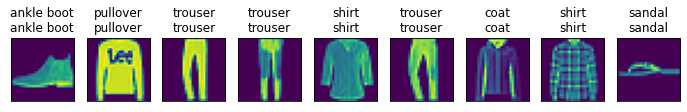

In [12]:
from matplotlib import pyplot as plt

def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_fashion_mnist(images, labels):
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

X, y = iter(test_iter).next()

true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

show_fashion_mnist(X[0:9], titles[0:9])